In [2]:
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt

import pyproj

import sys
#Tools for evaraging model data
sys.path.append(r'../tools')

In [3]:
def correct_vectors(n_u, n_v, lon0, lat0, b_x, b_y, timestep=3600.):
    """ Correct U, V vectors exported in neXtSIM 'Moorings.nc'
    
    Input
    -----
    n_u : 2D array with 'siu' from Moorings.nc
    n_v : 2D array with 'siv' from Moorings.nc
    lon0 : 2D array with 'lon' from barents_eps_*nc
    lat0 : 2D array with 'lat' from barents_eps_*nc
    b_x : 1D array with 'X' from barents_eps_*nc
    b_y : 1D array with 'Y' from barents_eps_*nc
    
    Returns
    -------
    b_u : 2D array with X component (U) of ice velocity in barents_eps_*nc coordinates
    b_v : 2D array with Y component (V) of ice velocity in barents_eps_*nc coordinates
    """
    nextsim_proj = pyproj.Proj('+proj=stere +a=6378273.0 +b=6356889.448910593 +lon_0=-45.0 +lat_0=90.0 +lat_ts=60.0 +type=crs')
    barents_proj = pyproj.Proj('+proj=lcc +lat_0=77.5 +lon_0=-25 +lat_1=77.5 +lat_2=77.5 +no_defs +R=6.371e+06')

    bx0_n, by0_n = nextsim_proj(lon0, lat0)
    
    bx1_n = bx0_n + n_u * timestep
    by1_n = by0_n + n_v * timestep

    lon1, lat1 = nextsim_proj(bx1_n, by1_n, inverse=True)
    bx1, by1 = barents_proj(lon1, lat1)
    bx0, by0 = np.meshgrid(b_x, b_y)
    
    b_u = (bx1 - bx0) / timestep
    b_v = (by1 - by0) / timestep
    b_u.mask = n_u.mask
    b_v.mask = n_v.mask

    return b_u, b_v


In [9]:
'''
nov22_date = 19 #19th Nov 2022
m_idx = int((nov22_date - 1)*24) 

#m2name = '/data1/antonk/tmp/Moorings_barents.nc'
m2name = '/home/jovyan/data/NERSC_model_data/NERSC_modelMoorings_barents.nc'
with Dataset(m2name) as ds:
    n_u = ds['siu'][m_idx]
    n_v = ds['siv'][m_idx]
'''

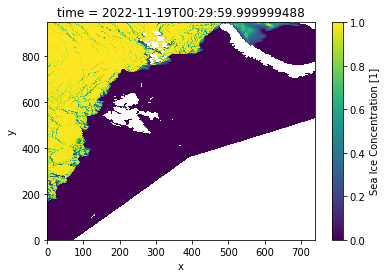

In [4]:
import xarray as xr

# Upload Barents2.5 data starting on 2022.11.19 at O6:00

data = xr.open_dataset('/home/jovyan/data/NERSC_model_data/NERSC_modelMoorings_barents.nc')
data.sic.sel(time='2022-11-19T00').plot()

In [5]:
data

<xarray.Dataset>
Dimensions:    (time: 589, nv: 2, y: 949, x: 739)
Coordinates:
  * time       (time) datetime64[ns] 2022-11-01T00:29:59.999999488 ... 2022-1...
    longitude  (y, x) float32 ...
    latitude   (y, x) float32 ...
Dimensions without coordinates: nv, y, x
Data variables:
    time_bnds  (time, nv) datetime64[ns] ...
    siu        (time, y, x) float32 ...
    siv        (time, y, x) float32 ...
    sic        (time, y, x) float32 ...
    sit        (time, y, x) float32 ...
Attributes:
    Conventions:  CF-1.6
    institution:  NERSC, Jahnebakken 3, N-5007 Bergen, Norway
    source:       neXtSIM model fields

In [6]:
'''
# Extract variables
n_u = ds['siu'][m_idx]
n_v = ds['siv'][m_idx]
# General variables
X = data['X']
Y = data['Y']
lon = data['lon']
lat = data['lat']
time = data['time']
model_proj4 = data.projection_lambert.proj4
'''
# Sea ice related variables
n_u = data['siu'] # ice velocity (x) 
n_v = data['siv'] # ice velocity (y)
siconc = data['sic'] # ice area  (aggregate)

In [7]:
from model_data_prep import round_start_time, round_end_time, time_difference

# SAR images timestamps
t_sar1 = '2022-11-19T07:22:08'
t_sar2 = '2022-11-20T08:02:59'

# Rounding the SAR timestamps to align with the nearest whole hour of model timestamps
t_start = round_start_time(t_sar1)
t_end = round_end_time(t_sar2)

print(f'SAR1 time is {t_sar1}, Model start time for the time period is {t_start}')
print(f'SAR2 time is {t_sar2}, Model end time for the time period is {t_end}')


# Extracting the model time variavle data corresponding to the time period between the rounded start and end times
time_period = data.time.sel(time=slice(t_start,t_end))

print(f'The duration of the time period is {len(time_period)-1} whole hours')

SAR1 time is 2022-11-19T07:22:08, Model start time for the time period is 2022-11-19T07:00:00
SAR2 time is 2022-11-20T08:02:59, Model end time for the time period is 2022-11-20T09:00:00
The duration of the time period is 25 whole hours


In [8]:
time_period

<xarray.DataArray 'time' (time: 26)>
array(['2022-11-19T07:30:00.000000000', '2022-11-19T08:30:00.000000000',
       '2022-11-19T09:29:59.999999488', '2022-11-19T10:30:00.000000000',
       '2022-11-19T11:30:00.000000000', '2022-11-19T12:29:59.999999488',
       '2022-11-19T13:30:00.000000000', '2022-11-19T14:30:00.000000000',
       '2022-11-19T15:29:59.999999488', '2022-11-19T16:30:00.000000000',
       '2022-11-19T17:30:00.000000000', '2022-11-19T18:29:59.999999488',
       '2022-11-19T19:30:00.000000000', '2022-11-19T20:30:00.000000000',
       '2022-11-19T21:29:59.999999488', '2022-11-19T22:30:00.000000000',
       '2022-11-19T23:30:00.000000000', '2022-11-20T00:29:59.999999488',
       '2022-11-20T01:30:00.000000000', '2022-11-20T02:30:00.000000000',
       '2022-11-20T03:29:59.999999488', '2022-11-20T04:30:00.000000000',
       '2022-11-20T05:30:00.000000000', '2022-11-20T06:29:59.999999488',
       '2022-11-20T07:30:00.000000000', '2022-11-20T08:30:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2022-11-19T07:30:00 ... 2022-11-20T08:30:00
Attributes:
    standard_name:  time
    long_name:      simulation time
    bounds:         time_bnds

In [9]:
%store -r time_diff_start
%store -r time_diff_end
%store -r total_time_diff

print(f'Time difference between SAR1 and the start of the model time period is {time_diff_start} seconds ({np.around(time_diff_start/60, 3)} minutes).') 
print(f'Time difference between SAR2 and the end of the model time period is {time_diff_end} seconds ({np.around(time_diff_end/60, 3)} minutes).')
print(f'Total time difference between SAR1 and SAR2 images is {total_time_diff} seconds  ({np.around(total_time_diff/86400, 3)} days).') 

Time difference between SAR1 and the start of the model time period is 1328 seconds (22.133 minutes).
Time difference between SAR2 and the end of the model time period is 3421 seconds (57.017 minutes).
Total time difference between SAR1 and SAR2 images is 88851 seconds  (1.028 days).


In [10]:
print(len(data.time), len(data.time_bnds))
time=time_period
for i, time in enumerate(time_period):
    print(f' time: {data.time.sel(time=time_period[i]).values}, end band {data.time_bnds[:,1].sel(time=time_period[i]).values}')


589 589
 time: 2022-11-19T07:30:00.000000000, end band 2022-11-19T08:00:00.000000000
 time: 2022-11-19T08:30:00.000000000, end band 2022-11-19T09:00:00.000000000
 time: 2022-11-19T09:29:59.999999488, end band 2022-11-19T10:00:00.000000000
 time: 2022-11-19T10:30:00.000000000, end band 2022-11-19T11:00:00.000000000
 time: 2022-11-19T11:30:00.000000000, end band 2022-11-19T12:00:00.000000000
 time: 2022-11-19T12:29:59.999999488, end band 2022-11-19T13:00:00.000000000
 time: 2022-11-19T13:30:00.000000000, end band 2022-11-19T14:00:00.000000000
 time: 2022-11-19T14:30:00.000000000, end band 2022-11-19T15:00:00.000000000
 time: 2022-11-19T15:29:59.999999488, end band 2022-11-19T16:00:00.000000000
 time: 2022-11-19T16:30:00.000000000, end band 2022-11-19T17:00:00.000000000
 time: 2022-11-19T17:30:00.000000000, end band 2022-11-19T18:00:00.000000000
 time: 2022-11-19T18:29:59.999999488, end band 2022-11-19T19:00:00.000000000
 time: 2022-11-19T19:30:00.000000000, end band 2022-11-19T20:00:00.0

#### 1) Importing bounds for subset from the notebook with drift calculation for SAR1 - SAR2.
It takes bounds from the sar image nansat object and the correspond directly to the tiff bound without buffer zone.
Drift data exported within this bounds would have the same grid, projection as algorithm data that make it easy to compare

In [11]:
#Import variables for extracting subsets from SAR1-SAR2_drift.ipynb
%store -r r
%store -r c
%store -r X_subset
%store -r Y_subset
%store -r lon_subset
%store -r lat_subset

In [12]:
X_subset.shape, Y_subset.shape, r.shape, c.shape, lon_subset.shape, lat_subset.shape

((160,), (154,), (14002,), (14002,), (154, 160), (154, 160))

In [13]:
len(n_u)

589

In [ ]:
for 
# Use this adjusment for every time step data
b_u, b_v = correct_vectors(n_u, n_v, lon0, lat0, b_x, b_y)

In [14]:
# Extract other varibles within the bound
#pick ensmble

ice_u_subset = n_u.sel(time=slice(t_start,t_end))[:, min(r):max(r)+1, min(c):max(c)+1].fillna(np.nan)
ice_v_subset = n_v.sel(time=slice(t_start,t_end))[:, min(r):max(r)+1, min(c):max(c)+1].fillna(np.nan)
siconc_subset  = siconc.sel(time=slice(t_start,t_end))[:, min(r):max(r)+1, min(c):max(c)+1].fillna(np.nan)


In [16]:
b_u_list = []
b_v_list = []

for i in range(len(ice_u_subset)):
    temp_b_u, temp_b_v = correct_vectors(ice_u_subset[i], ice_v_subset[i], lon_subset, lat_subset, X_subset, Y_subset)
    b_u_list.append(temp_b_u)
    b_v_list.append(temp_b_v)


AttributeError: 'DataArray' object has no attribute 'mask'

In [54]:
xx, yy, int_dx, int_dy = cumulative_ice_displacement(X_subset,Y_subset, ice_u_subset, ice_v_subset,time_period, time_diff_start,time_diff_end)


0 hour done
1 hour done
2 hour done
3 hour done
4 hour done
5 hour done
6 hour done
7 hour done
8 hour done
9 hour done
10 hour done
11 hour done
12 hour done
13 hour done
14 hour done
15 hour done
16 hour done
17 hour done
18 hour done
19 hour done
20 hour done
21 hour done
22 hour done
23 hour done
24 hour done
25 hour done


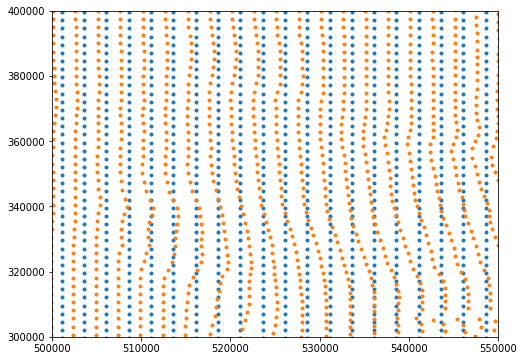

In [57]:
space_step=1

plt.figure(figsize=(8, 6))

plt.plot(xx[0][::space_step], yy[0][::space_step], '.')
#plt.plot(xx[10][::space_step], yy[10][::space_step], '.')
plt.plot(xx[26][::space_step], yy[26][::space_step], '.')
plt.xlim([5e5, 5.5e5])
plt.ylim([3e5, 4e5])

plt.show()

In [58]:
output_dir_subset_comp =  r'/home/jovyan/data/model_data_process_output/for_comparison_lambert'

In [59]:
lon1 = lon_subset.data.flatten()
lat1 = lat_subset.data.flatten()

In [62]:
import pandas as pd
import os
import csv
points=zip(lon1, lat1, int_dx[-1], int_dy[-1])
header=['lon1','lat1', 'du','dv']

time_index_start = pd.to_datetime(time_period[0].values)
time_index_end = pd.to_datetime(time_period[-1].values)
filename_t_start = time_index_start.strftime('%Y%m%dT%H')
filename_t_end = time_index_end.strftime('%Y%m%dT%H')
        
file_name = f'total_nextsim_displacement_{filename_t_start}-{filename_t_end}.csv'
file_path = os.path.join(output_dir_subset_comp, file_name)

with open(file_path, 'w', newline='') as csv_file:
            out = csv.writer(csv_file, delimiter=',')
            out.writerow(header)
            out.writerows(points)

In [52]:
for t in range(0,len(time_period)):
    print(t, t == t in range(1, len(time_period)-1), t == len(time_period)-1, t == 0)

0 False False True
1 True False False
2 True False False
3 True False False
4 True False False
5 True False False
6 True False False
7 True False False
8 True False False
9 True False False
10 True False False
11 True False False
12 True False False
13 True False False
14 True False False
15 True False False
16 True False False
17 True False False
18 True False False
19 True False False
20 True False False
21 True False False
22 True False False
23 True False False
24 True False False
25 False True False


In [53]:
from scipy.interpolate import RegularGridInterpolator
def cumulative_ice_displacement(X, Y, ice_u, ice_v, time_period, time_diff_start, time_diff_end):
    """
    Computes the integrated displacement along the x and y axes for each hour (or its fraction) of the forecasting  time period. 
    The calculation for each hour is cumulative. For instance, the displacement value at the 1st hour represents the displacement 
    for that hour alone, while the value at the 5th hour represents the cumulative displacement over the first five hours.
    Such displacmeents are intended for drift-driven warping
    
    This function also derives the hourly coordinates (xx and yy) in the Lagrangian reference frame, where the model coordinates 
    X and Y serve as the starting grid coordinates.

    Parameters:
    - X, Y (DataArray): Cartesian coordinates from the model or its subset.
    - ice_u, ice_v (DataArray): Ice velocities along the x and y axes, respectively.
    - time_period (DataArray): The input xarray model time period.
    - time_diff_start (int): Time difference in seconds between SAR1 and the start of the model time period.
    - time_diff_end (int): Time difference in seconds between SAR2 and the end of the model time period.

    Returns: 
    - xx, yy (list): Lists of coordinates corresponding to each timestamp in the time period. The lengths of xx and yy are equivalent to len(time_period).
    - int_dx, int_dy (list): Lists of total cumulative displacements for each hour of the time period. The lengths of int_dx and int_dy are len(time_period) - 1.
    """


    # Create coordinate arrays  
    x_sub, y_sub = np.meshgrid(X, Y)
    # Turn arrays into vectors
    x_sub = x_sub.flatten()
    y_sub = y_sub.flatten()

    # Store the selected coordinate arrays in lists to collect arrays from different iterationsfor further processing
    xx = [x_sub]
    yy = [y_sub]

    #Prepare lsit for integrated drift for comparison with model
    int_dx = []
    int_dy = []

    for t in range(len(time_period)):
        print(f'{t} hour done')
        u = ice_u.sel(time=time_period[t])#
        
        v = ice_v.sel(time=time_period[t])
   
        # Calculate displacement along lon (u) and lat (v) based on mean velovity
        # The first and the last displacemnets are calculated differently based on time difference with the SAR acquisitions
        if t == 0:
            u_displacement = (u)*(3600-time_diff_start)
            v_displacement = (v)*(3600-time_diff_start)
            #print("start", t, u_displacement.values)
        elif t in range(1, len(time_period)-1):
            u_displacement = (u)*3600/2
            v_displacement = (v)*3600/2
            #print(t, u_displacement.values)
        elif t == len(time_period)-1:
            u_displacement = (u)*(3600-time_diff_end)/2
            v_displacement = (v)*(3600-time_diff_end)/2
            #print("end", t, u_displacement.values)

        # Create interpolator object with grid coordinates and corresponded drift values
        ut_interpolator = RegularGridInterpolator((Y.data,X.data), u_displacement.data, bounds_error=False, fill_value = None)
        dx = ut_interpolator((y_sub, x_sub))
        #print("dx", dx)
        vt_interpolator = RegularGridInterpolator((Y.data,X.data), v_displacement.data, bounds_error=False, fill_value = None)
        dy = vt_interpolator((y_sub, x_sub)) 
        #print("dy", dy)
        # Calculate new coordinates based on displacement 
        x_sub = x_sub + dx
        y_sub = y_sub + dy
        # Append them to the list
        xx.append(x_sub)
        yy.append(y_sub)


        #Calculate total integrated drift
        if t == 0:
            dx_total = dx
            dy_total = dy
            int_dx.append(dx_total)
            int_dy.append(dy_total)
        else:
            dx_total = int_dx[-1] + dx
            dy_total = int_dy[-1] + dy
            int_dx.append(dx_total)
            int_dy.append(dy_total)
            
    return xx, yy, int_dx, int_dy

In [8]:
with Dataset('https://thredds.met.no/thredds/dodsC/fou-hi/barents_eps_eps/barents_eps_20221119T00Z.nc') as ds:
    b_x = ds['X'][:]
    b_y = ds['Y'][:]    
    lon0 = ds['lon'][:]
    lat0 = ds['lat'][:]
    # OPTIONAL:
    ice_u = ds['ice_u'][0,0]
    ice_v = ds['ice_v'][0,0]


In [ ]:
# Use this adjusment for every time step data
b_u, b_v = correct_vectors(n_u, n_v, lon0, lat0, b_x, b_y)    

#### Calculated inegrated drift

In [ ]:
step = 5

fig, axs = plt.subplots(1,2,figsize=(20,10))
axs[0].quiver(b_x[::step], b_y[::step], b_u[::step, ::step], b_v[::step, ::step], np.hypot(b_u[::step, ::step], b_v[::step, ::step]), angles='xy', scale_units='xy', scale=0.000005, cmap='jet', clim=[0, 0.5])
axs[0].set_xlim([0.3e6,1.3e6])
axs[0].set_ylim([0,1e6])
axs[0].set_aspect('equal')

axs[1].quiver(b_x[::step], b_y[::step], ice_u[::step, ::step], ice_v[::step, ::step], np.hypot(ice_u[::step, ::step], ice_v[::step, ::step]), angles='xy', scale_units='xy', scale=0.000005, cmap='jet', clim=[0, 0.5])
axs[1].set_xlim([0.3e6,1.3e6])
axs[1].set_ylim([0,1e6])
axs[1].set_aspect('equal')

plt.show()

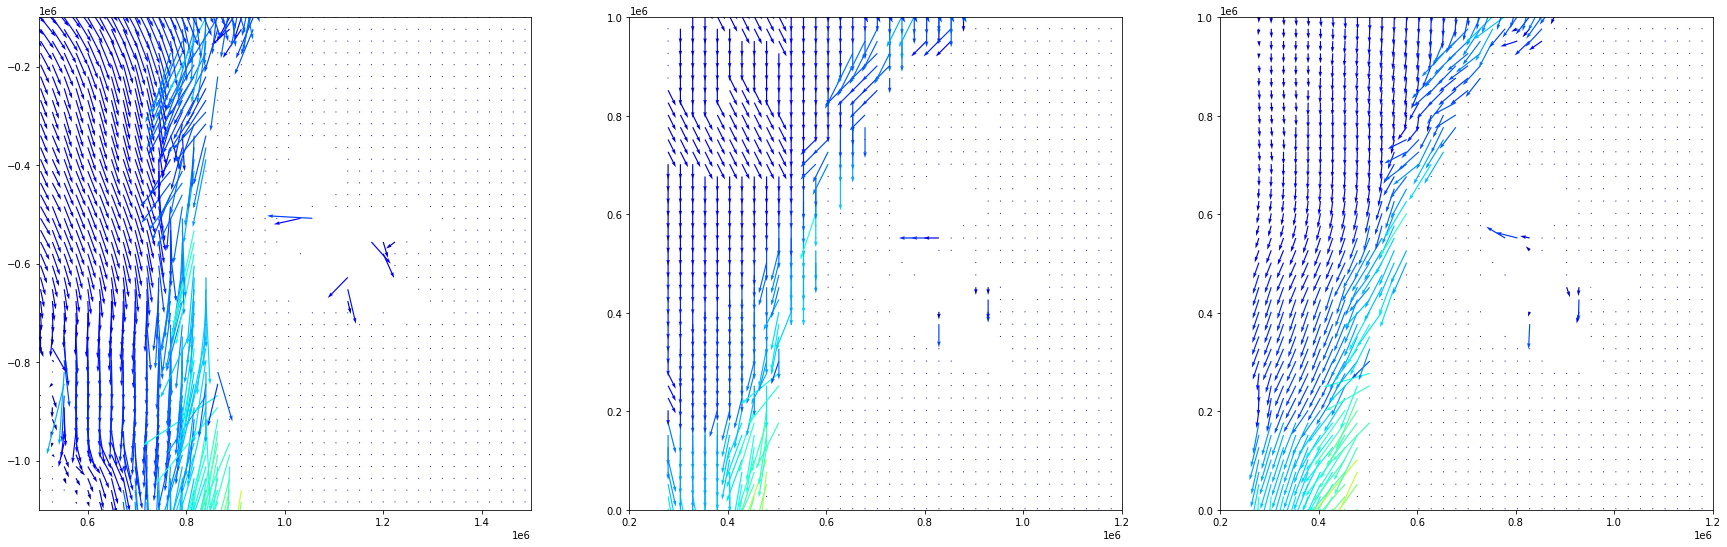

In [7]:
# JUST FOR COMPARISON WITH ANOTHER GRID

with Dataset('/data1/antonk/tmp/Moorings_barents.nc') as ds:
    n_u = ds['siu'][23]
    n_v = ds['siv'][23]

with Dataset('/data1/antonk/tmp/Moorings_2022d305.nc') as ds:
    t_u = ds['siu'][47]
    t_v = ds['siv'][47]

with Dataset('/Data/sim/data/nextsim_output_grids/topaz6_grid.nc') as ds:
    t_x = ds['x'][:] * 100000
    t_y = ds['y'][:] * 100000

b_u, b_v = correct_vectors(n_u, n_v, lon0, lat0, b_x, b_y)    
    
fig, axs = plt.subplots(1,3,figsize=(30,10))
step = 8
#axs[0].pcolormesh(m1x[::step], m1y[::step], , cmap='jet', vmin=0, vmax=0.1)
axs[0].quiver(t_x[::step], t_y[::step], t_u[::step, ::step], t_v[::step, ::step], np.hypot(t_u[::step, ::step], t_v[::step, ::step]), angles='xy', scale_units='xy', scale=0.000001, cmap='jet', clim=[0, 0.5])
axs[0].set_xlim([0.5e6,1.5e6])
axs[0].set_ylim([-1.1e6,-0.1e6])
axs[0].set_aspect('equal')

step = 10
#axs[1].pcolormesh(m2x[::step], m2y[::step],  cmap='jet', vmin=0, vmax=0.1)
axs[1].quiver(b_x[::step], b_y[::step], n_u[::step, ::step], n_v[::step, ::step], np.hypot(n_u[::step, ::step], n_v[::step, ::step]), angles='xy', scale_units='xy', scale=0.000002, cmap='jet', clim=[0, 0.5])
axs[1].set_xlim([0.2e6,1.2e6])
axs[1].set_ylim([0,1e6])
axs[1].set_aspect('equal')

#axs[2].pcolormesh(m2x[::step], m2y[::step], cmap='jet', vmin=0, vmax=0.1)
axs[2].quiver(b_x[::step], b_y[::step], b_u[::step, ::step], b_v[::step, ::step], np.hypot(b_u[::step, ::step], b_v[::step, ::step]), angles='xy', scale_units='xy', scale=0.000002, cmap='jet', clim=[0, 0.5])
axs[2].set_xlim([0.2e6,1.2e6])
axs[2].set_ylim([0,1e6])
axs[2].set_aspect('equal')

plt.show()